## 2.1a Loading data and basic operations

In [80]:
import geopandas as gpd
import pandas as pd
import json

# Load points
geo_points = gpd.read_file("proj4_points.geojson")
geo_points.to_crs(epsg=2180, inplace=True)

spacial_index = geo_points.sindex # spatial index for faster queries

with open("proj4_params.json") as f:
    data = json.load(f)
    id_column = data["id_column"]
print(id_column)


geo_points['buffer_geom'] = geo_points.geometry.buffer(100)
df_joins = gpd.sjoin(
    geo_points[[id_column, 'geometry']],
    geo_points.set_geometry('buffer_geom'),
)

df_joins.rename(columns={f'{id_column}_left': id_column}, inplace=True)

# Count points in buffer
counts = df_joins.groupby(id_column).count()
counts = counts.reset_index()
counts = counts[[id_column, "index_right"]]
counts.columns = [id_column, "count"]

counts[[id_column, "count"]].to_csv("proj4_ex01_counts.csv", index=False)


lamp_id


## 2.1b

In [81]:
geo_point2_1 = geo_points.to_crs(epsg=4326)

geo_point2_1['lon'] = geo_point2_1.geometry.x
geo_point2_1['lat'] = geo_point2_1.geometry.y

geo_point2_1[[id_column, "lon", "lat"]].to_csv("proj4_ex01_coords.csv", index=False)

## 2.2 Loading data from OpenStreetMap

In [82]:

import osmnx as ox
print(data)
city_name = data["city"]
city_name = "Kraków" if city_name == "Cracow" else ('Warszawa' if city_name == "Warsaw" else city_name)

G = ox.graph_from_place(f"{city_name}, Poland", network_type="drive", custom_filter='["highway"="primary"]')
geo_df = ox.graph_to_gdfs(G, nodes=False, edges=True)
geo_df = geo_df.rename(columns={"osmid": "osm_id"})

geo_df = geo_df[["osm_id", "name", "geometry"]]
geo_df["osm_id"] = geo_df["osm_id"].astype(str)
geo_df["name"] = geo_df["name"].astype(str)

geo_df.to_file("proj4_ex02_primary_roads.geojson", driver="GeoJSON", index=False)
geo_df

{'city': 'Cracow', 'id_column': 'lamp_id'}


osm_id  \
u           v           key                                                      
4577327232  4577327233  0                                            813408227   
            5940565238  0                     [25047290, 813408236, 813408238]   
4577327233  869474656   0                                            797806850   
213635848   32063411    0                      [216686693, 216231365, 4908479]   
            213636363   0                                             29597187   
213636363   213636697   0                     [37828105, 148978818, 148978819]   
32063271    32063274    0          [148469691, 549215957, 148469686, 37828103]   
32063274    32063411    0                                [37828104, 549215953]   
            213636363   0    [932235205, 216231369, 453609840, 1087324497, ...   
32063403    206368892   0    [732685222, 148469610, 19801868, 148469617, 54...   
            32063271    0                                [549215955, 19801869]   
1541292462  1262667324  0    [1091208960, 391115780, 690233477, 391115781, ...   
            1541292515  0                                            405498220   
32063411    32063403    0          [148469690, 549215954, 37828098, 148469692]   
1262667324  4577327232  0                                            813408237   
            34806225    0                               [797812628, 173295820]   
10757297085 10757297086 0                                           1156779981   
            1542271716  0    [1156788934, 913838151, 755332751, 25741680, 2...   
10757297086 10757310825 0                             [1156788932, 1156788933]   
32063423    213635848   0                     [148978816, 37828097, 148978817]   
1542271684  10757297086 0    [1156788932, 913838150, 5095979, 537125259, 25...   
            1542271716  0                                            405498225   
34806225    4577327232  0                     [73306216, 813408229, 813408230]   
213636697   32063423    0                                             37828106   
869474656   1262667324  0                                            813408228   
            1541292515  0    [1122699141, 1080474630, 1122699142, 108047463...   
13823459    4232232955  0           [37831088, 24905014, 444150756, 905181438]   
1542271716  1541292462  0                                            405498228   
13823461    13823459    0                                            157627309   
            206368891   0          [157627315, 217138564, 217138566, 37831087]   
1541292515  1542271684  0                                            405498226   
10757310825 13823461    0    [29401004, 553076429, 553076430, 217138555, 55...   
            10757310826 0                                           1156780307   
10757310826 10757297085 0                              [343791933, 1156788935]   
206368891   206368892   0                                             37828102   
            32063271    0    [148469607, 545433850, 148469613, 148469615, 4...   
5940565238  4577327233  0                               [462328002, 813408239]   
4232232955  13823461    0                                             19803388   
            10757310826 0    [37828101, 343791933, 553077363, 553077364, 14...   
206368892   13823459    0                                [37828099, 217138565]   

                                                                          name  \
u           v           key                                                      
4577327232  4577327233  0                                              Brzeska   
            5940565238  0                                            Igołomska   
4577327233  869474656   0                                            Igołomska   
213635848   32063411    0                    Aleja generała Władysława Andersa   
            213636363   0                     Rondo Generała Stanisława Maczka   
213636363   213636697   0                     Rondo G

## 2.3

In [83]:
points = gpd.read_file("proj4_points.geojson")
points = points.to_crs(epsg=2180)

roads = geo_df

for road in roads.itertuples():
    # bounding box of a 50-metre buffer around the road
    box_50m = road.geometry.buffer(50).bounds
    candidates = points.sindex.intersection(box_50m)
    
    # Filter the candidates by actual distance
    neighbours = points.loc[candidates].distance(road.geometry) <= 50
    roads.loc[road.Index, "count"] = neighbours.count()


roads = roads.groupby("name").count()
roads = roads[["count"]]
roads = roads.rename(columns={"count": "point_count"})
print(roads.columns)
roads.to_csv("proj4_ex03_streets_points.csv")



Index(['point_count'], dtype='object')


/tmp/ipykernel_1532/2387350384.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  roads.loc[road.Index, "count"] = neighbours.count()
/tmp/ipykernel_1532/2387350384.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  roads.loc[road.Index, "count"] = neighbours.count()
/tmp/ipykernel_1532/2387350384.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  roads.loc[road.Index, "count"] = neighbours.count()
/tmp/ipykernel_1532/2387350384.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  roads.loc[road.Index, "count"] = neighbours.count()
/tmp/ipykernel_1532/2387350384.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  roads.loc[road.Index, "count"] = neighbours.count()
/tmp/ipykernel_1532/2387350384.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  roads.loc[road.Index, "count"] = neighbours.count()
/tmp/ipykernel_1

## 2.4


Countries:        name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

/home/lenovo/miniconda3/envs/geoenv/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/home/lenovo/miniconda3/envs/geoenv/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/home/lenovo/miniconda3/envs/geoenv/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/home/lenovo/miniconda3/envs/geoenv/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 21 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


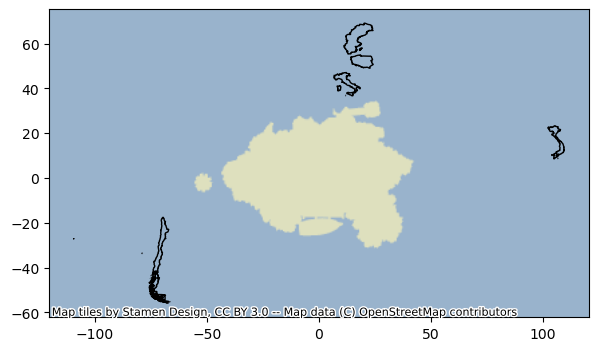

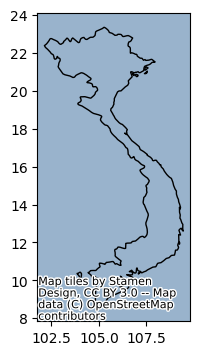

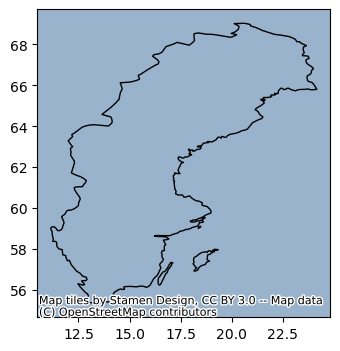

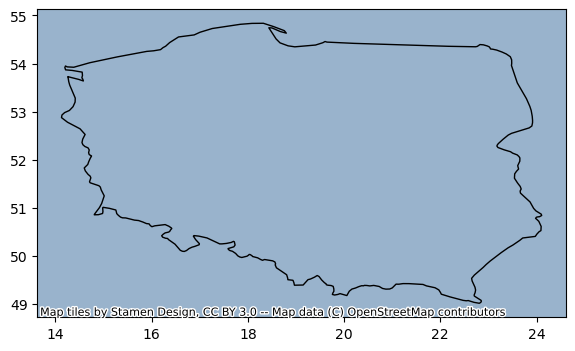

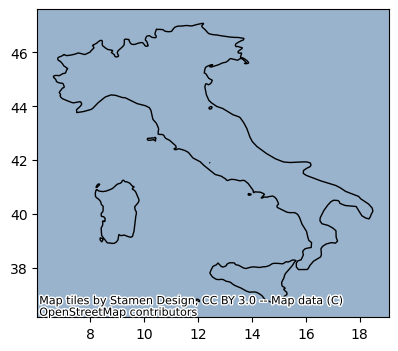

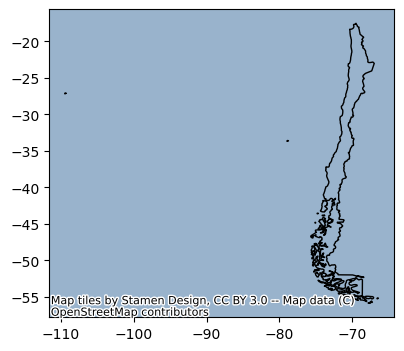

In [84]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

gdf = gpd.read_file("proj4_countries.geojson")
print("Countries: ", gdf.to_string())
gdf.to_pickle("proj4_ex04_gdf.pkl")

# plot all to the world map
ax = gdf.plot(edgecolor="black", facecolor="none", figsize=(8, 4))
ctx.add_basemap(ax)

for country in gdf["name"]:
    gdf_country = gdf[gdf["name"] == country]
 
    # plot the country boundary with a background map
    ax = gdf_country.plot(edgecolor="black", facecolor="none", figsize=(8, 4))
    ctx.add_basemap(ax)
 
    plt.savefig(f"proj4_ex04_{country.lower()}.png")